In [1]:
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from mpl_toolkits import mplot3d
from klepto.archives import dir_archive
import cv2
import time
from scipy.io import savemat

In [2]:
BEDFORMS = ['corals', 'canopy', 'rocks', 'dunes']
flow_speeds = ['fast', 'med', 'slow']
submergences = ['Deep', 'Intermed', 'Shallow']
colors = {'corals':'dodgerblue','canopy':'green', 'rocks':'orange', 'dunes':'brown'}

In [3]:
bed_idx = 2
flow_idx = 2
submergence_idx = 1
TEST = 2
BATCH_FRAMES =  75# for data acquired at 3 fp, total of 900, per subfolder 225 frames. 225/75 = 9

# SET the data variables
FLOW_SPEED = flow_speeds[flow_idx]
SUBMERGENCE = submergences[submergence_idx]
BEDFORM = BEDFORMS[bed_idx]

## PSD using 2D FFT

In [4]:
for i in [1,2,3,4]:#range(1,5):
    # choose the data
    SUBFOLDER = i

    # source data folders
    data_foldername = "{}_{}Flow_{}H_test{}_subFolder{}".format(BEDFORM, FLOW_SPEED, SUBMERGENCE, TEST, SUBFOLDER)
    print(data_foldername)
    data_location =  "../FLIR_Camera"#'../TOSHIBA_Drive/saksham_polar_cam_FLIR'
    save_location =  "../FLIR_Camera"
    klepto_saved_data_origin = 'klepto_bulk_data_saves' 

    # retrive the saved data
    data_origin = os.path.join(data_location, klepto_saved_data_origin, data_foldername)
    bed_data ={BEDFORM:{}}
    tic = time.time()
    assert os.path.exists(data_origin) == True
    data = dir_archive(data_origin, {}, serialized=True, cached=False)
    bed_data[BEDFORM]['all_slopeMag_maps'], bed_data[BEDFORM]['all_slopeAzi_maps']\
                = cv2.cartToPolar(data['all_sy_maps'], data['all_sx_maps'], angleInDegrees=True)
#     bed_data[BEDFORM]['all_slopeMag_maps'] = np.sqrt(data['all_sx_maps']**2 + data['all_sy_maps']**2)
#     bed_data[BEDFORM]['all_slopeAzi_maps'] = np.arctan(data['all_sy_maps']/data['all_sx_maps'])
    del data
    toc = time.time()
    print("time taken to load the data  = ", toc-tic)

    NUM_FRAMES = bed_data[BEDFORM]['all_slopeMag_maps'].shape[-1]

    # Accumulate the mean PSD of every BATCH_SIZE frames 
    if SUBFOLDER==1:
        slopeMag_hat_mag_mean = []
        slopeAzi_hat_mag_mean = []

    for i in range(NUM_FRAMES//BATCH_FRAMES):    

        slopeMag_hat = np.fft.fft2(bed_data[BEDFORM]['all_slopeMag_maps'][:,:,i*BATCH_FRAMES:(i+1)*BATCH_FRAMES], axes = ([0,1]))
        print(slopeMag_hat.shape)
        slopeMag_hat = np.fft.fftshift(slopeMag_hat)
        slopeMag_hat_mag = (np.log(np.abs(slopeMag_hat)))**2

        slopeAzi_hat = np.fft.fft2(bed_data[BEDFORM]['all_slopeAzi_maps'][:,:,i*BATCH_FRAMES:(i+1)*BATCH_FRAMES], axes = ([0,1]))
        slopeAzi_hat = np.fft.fftshift(slopeAzi_hat) # DC content at the center
        slopeAzi_hat_mag = (np.log(np.abs(slopeAzi_hat)))**2

        slopeMag_hat_mag_mean.append(np.mean(slopeMag_hat_mag, axis = (2)))
        slopeAzi_hat_mag_mean.append(np.mean(slopeAzi_hat_mag, axis = (2)))

    del bed_data, slopeMag_hat, slopeAzi_hat, slopeMag_hat_mag, slopeAzi_hat_mag

rocks_slowFlow_IntermedH_test2_subFolder1
time taken to load the data  =  16.808489084243774
(1024, 1224, 75)
(1024, 1224, 75)
(1024, 1224, 75)
rocks_slowFlow_IntermedH_test2_subFolder2
time taken to load the data  =  16.77655863761902
(1024, 1224, 75)
(1024, 1224, 75)
(1024, 1224, 75)
rocks_slowFlow_IntermedH_test2_subFolder3
time taken to load the data  =  16.5663480758667
(1024, 1224, 75)
(1024, 1224, 75)
(1024, 1224, 75)
rocks_slowFlow_IntermedH_test2_subFolder4
time taken to load the data  =  16.465198516845703
(1024, 1224, 75)
(1024, 1224, 75)
(1024, 1224, 75)


### Plot Power Spectral Density Ensemble Averages (slopes x,y)

In [5]:
FreqCompRows = np.fft.fftfreq(slopeMag_hat_mag_mean[0].shape[0],d=1)
FreqCompCols = np.fft.fftfreq(slopeMag_hat_mag_mean[0].shape[1],d=1)
FreqCompRows = np.fft.fftshift(FreqCompRows)
FreqCompCols = np.fft.fftshift(FreqCompCols)

R,C = np.meshgrid(FreqCompRows, FreqCompCols)
M,N = slopeMag_hat_mag_mean[0].shape[0:2]

In [6]:
slopeMag_mean  = slopeMag_hat_mag_mean[0]
slopeAzi_mean  = slopeAzi_hat_mag_mean[0]
instances = len(slopeMag_hat_mag_mean)
print("number of frames to average: ", instances)
for i in range(1,instances):
    slopeMag_mean += slopeMag_hat_mag_mean[i]
    slopeAzi_mean += slopeAzi_hat_mag_mean[i]
slopeMag_hat_mag_mean = slopeMag_mean/instances
slopeAzi_hat_mag_mean = slopeAzi_mean/instances

number of frames to average:  12


<Figure size 432x288 with 0 Axes>

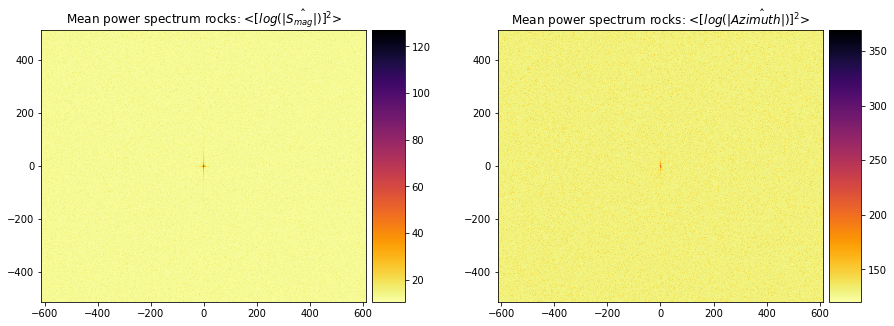

In [7]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(1,2, figsize =(15, 5)) 

ax0.set_title("Mean power spectrum {}: ".format(BEDFORM)+ "$\less [log(|\\hat{S_{mag}}|)]^2 \greater$", fontsize=  12)
im0 = ax0.imshow(slopeMag_hat_mag_mean, cmap = plt.cm.inferno_r, aspect='auto'\
                ,extent=(-N // 2, N // 2, -M // 2, M // 2))#, vmin = 0, vmax = 255)
divider0 = make_axes_locatable(ax0)
cax0 = divider0.append_axes("right", size="10%", pad=0.08)
cbar0 = plt.colorbar(im0, cax=cax0)
ax0.set_aspect('equal')

ax1.set_title("Mean power spectrum {}: ".format(BEDFORM)+ "$\less [log(|\\hat{Azimuth}|)]^2 \greater$", fontsize=  12)
im1 = ax1.imshow(slopeAzi_hat_mag_mean, cmap = plt.cm.inferno_r, aspect='auto'\
                , extent=(-N // 2, N // 2, -M // 2, M // 2)) # vmin = -5, vmax = 5, 
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="10%", pad=0.08)
cbar1 = plt.colorbar(im1, cax=cax1)
ax1.set_aspect('equal')

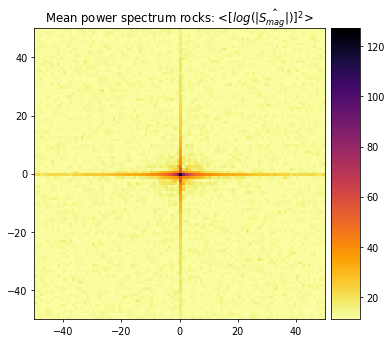

In [8]:
lim = 100

w = 6
h = 6
d = 70
ax0 = plt.figure(figsize=(w, h), dpi=d).gca()
ax0.set_title("Mean power spectrum {}: ".format(BEDFORM)+ "$\less [log(|\\hat{S_{mag}}|)]^2 \greater$", fontsize=  12)
im0 = ax0.imshow(slopeMag_hat_mag_mean[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2] , \
                 cmap = plt.cm.inferno_r, aspect='auto'\
                ,extent=(-lim// 2, lim// 2, -lim // 2, lim // 2))#, vmin = 0, vmax = 255)
divider0 = make_axes_locatable(ax0)
cax0 = divider0.append_axes("right", size="10%", pad=0.08)
cbar0 = plt.colorbar(im0, cax=cax0)
ax0.set_aspect('equal')
filename = 'ZOOMED_mean_slope_magnitude_spectrum_{}_{}Flow_{}H_test{}.png'.format(BEDFORM, FLOW_SPEED, SUBMERGENCE, TEST)
save_dest = os.path.join(save_location, klepto_saved_data_origin, filename)
plt.savefig(save_dest)
plt.show()

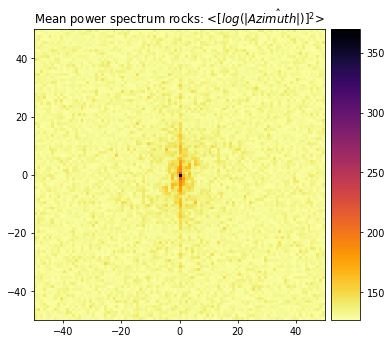

In [9]:
ax1 = plt.figure(figsize=(w, h), dpi=d).gca()
ax1.set_title("Mean power spectrum {}: ".format(BEDFORM)+ "$\less [log(|\\hat{Azimuth}|)]^2 \greater$", fontsize=  12)
im1 = ax1.imshow(slopeAzi_hat_mag_mean[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2], \
                 cmap = plt.cm.inferno_r, aspect='auto'\
                , extent=(-lim// 2, lim// 2, -lim // 2, lim // 2)) # vmin = -5, vmax = 5, 
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="10%", pad=0.08)
cbar1 = plt.colorbar(im1, cax=cax1)
ax1.set_aspect('equal')
filename = 'ZOOMED_mean_slope_azimuth_spectrum_{}_{}Flow_{}H_test{}.png'.format(BEDFORM, FLOW_SPEED, SUBMERGENCE, TEST)
save_dest = os.path.join(save_location, klepto_saved_data_origin, filename)
plt.savefig(save_dest)
plt.show()

In [10]:
# lim = 200
# plt.figure()
# fig, (ax0, ax1) = plt.subplots(1,2, figsize =(15, 5)) 

# ax0.set_title("Mean power spectrum {}: ".format(BEDFORM)+ "$\less [log(|\\hat{s_x}|)]^2 \greater$", fontsize=  12)
# # im0 = ax0.imshow(s_hat_x_mag_mean[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2] , \
# #                  cmap = plt.cm.inferno_r, aspect='auto'\
# #                 ,extent=(-lim// 2, lim// 2, -lim // 2, lim // 2))#, vmin = 0, vmax = 255)
# im0 = ax0.contour(R[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2],\
#                   C[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2],\
#                  s_hat_x_mag_mean[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2], 10, camp = 'RdGy')
# divider0 = make_axes_locatable(ax0)
# cax0 = divider0.append_axes("right", size="10%", pad=0.08)
# cbar0 = plt.colorbar(im0, cax=cax0)


# ax1.set_title("Mean power spectrum {}: ".format(BEDFORM)+ "$\less [log(|\\hat{s_y}|)]^2 \greater$", fontsize=  12)
# # im1 = ax1.imshow(s_hat_y_mag_mean[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2], \
# #                  cmap = plt.cm.inferno_r, aspect='auto'\
# #                 , extent=(-lim// 2, lim// 2, -lim // 2, lim // 2)) # vmin = -5, vmax = 5, 
# im1 = ax1.contour(R[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2],\
#                   C[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2],\
#                  s_hat_y_mag_mean[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2], 10, camp = 'RdGy')
# divider1 = make_axes_locatable(ax1)
# cax1 = divider1.append_axes("right", size="10%", pad=0.08)
# cbar1 = plt.colorbar(im1, cax=cax1)

# filename = 'ZOOMED_mean_PSD_Contour_{}_{}Flow_{}H_test{}.png'.format(BEDFORM, FLOW_SPEED, SUBMERGENCE, TEST)
# save_dest = os.path.join(save_location, klepto_saved_data_origin, filename)
# plt.savefig(save_dest)
# plt.show()

## Save the 3D FFT (for x,y,t) to visualize using Slicing in Matlab

In [11]:
# NUM_SUBFOLDERS = 4
# for i in range(1,5):

#     # source data folders
#     data_foldername = "{}_{}Flow_{}H_test{}_subFolder{}".format(BEDFORM, FLOW_SPEED, SUBMERGENCE, TEST, SUBFOLDER)
#     print(data_foldername)
#     data_location =  "../FLIR_Camera"
#     save_location =  "../FLIR_Camera"
#     klepto_saved_data_origin = 'klepto_bulk_data_saves' 

#     # retrive the saved data
#     data_origin = os.path.join(save_location, klepto_saved_data_origin, data_foldername)
#     bed_data ={BEDFORM:{}}
#     tic = time.time()
#     assert os.path.exists(data_origin) == True
#     data = dir_archive(data_origin, {}, serialized=True, cached=False)
#     bed_data[BEDFORM]['all_sx_maps'] = data['all_sx_maps']
#     bed_data[BEDFORM]['all_sy_maps'] = data['all_sy_maps']
#     del data
#     toc = time.time()
#     print("time taken to load the data  = ", toc-tic)

#     NUM_FRAMES = bed_data[BEDFORM]['all_sx_maps'].shape[-1]

#     # Accumulate the mean PSD of every BATCH_SIZE frames 
#     instances  = NUM_FRAMES//BATCH_FRAMES
#     for i in range(NUM_FRAMES//BATCH_FRAMES):    

#         s_hat_x = np.fft.fftn(bed_data[BEDFORM]['all_sx_maps'][:,:,i*BATCH_FRAMES:(i+1)*BATCH_FRAMES], \
#                               axes = ([0,1,2]))
#         s_hat_x = np.fft.fftshift(s_hat_x)
#         s_hat_x_PSD = (np.log(np.abs(s_hat_x)))**2

#         s_hat_y = np.fft.fftn(bed_data[BEDFORM]['all_sy_maps'][:,:,i*BATCH_FRAMES:(i+1)*BATCH_FRAMES], \
#                               axes = ([0,1,2]))
#         s_hat_y = np.fft.fftshift(s_hat_y) # DC content at the center
#         s_hat_y_PSD = (np.log(np.abs(s_hat_y)))**2
        
#         if i==0:
#             M,N,K = s_hat_x_PSD.shape
#             lim = 80 # total window aroun 0 frequency    
#             s_hat_x_mag = s_hat_x_PSD[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2,:] 
#             s_hat_y_mag = s_hat_y_PSD[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2,:] 
#         else:
#             s_hat_x_mag += s_hat_x_PSD[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2,:] 
#             s_hat_y_mag += s_hat_y_PSD[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2,:]
    
#     print("number of frames to average: ", instances)
#     if SUBFOLDER==1:
#         s_hat_x_mag_mean = s_hat_x_mag/instances
#         s_hat_y_mag_mean = s_hat_y_mag/instances
#     else:
#         s_hat_x_mag_mean += s_hat_x_mag/instances
#         s_hat_y_mag_mean += s_hat_y_mag/instances

#     del bed_data, s_hat_x, s_hat_y, s_hat_x_PSD, s_hat_y_PSD, s_hat_x_mag, s_hat_y_mag

In [12]:
# s_hat_x_mag_mean = s_hat_x_mag_mean/NUM_SUBFOLDERS 
# s_hat_y_mag_mean = s_hat_y_mag_mean/NUM_SUBFOLDERS
# print(s_hat_x_mag_mean.shape)

In [13]:
# FreqCompRows = np.fft.fftfreq(s_hat_x_mag_mean.shape[0],d=1)
# FreqCompCols = np.fft.fftfreq(s_hat_x_mag_mean.shape[1],d=1)
# FreqCompVert = np.fft.fftfreq(s_hat_x_mag_mean.shape[2],d=1)
# FreqCompRows = np.fft.fftshift(FreqCompRows)
# FreqCompCols = np.fft.fftshift(FreqCompCols)
# FreqCompVert = np.fft.fftshift(FreqCompVert)

# R,C,V = np.meshgrid(FreqCompRows, FreqCompCols, FreqCompVert)
# print(s_hat_x_mag_mean.shape, FreqCompRows.shape, FreqCompCols.shape, FreqCompVert.shape)

In [14]:
# dic = {"R":R,"C":C,"V":V \
#          ,"FreqCompRows":FreqCompRows, "FreqCompCols":FreqCompCols, "FreqCompVert":FreqCompVert\
#         ,"s_hat_x_mag_mean":s_hat_x_mag_mean, "s_hat_y_mag_mean":s_hat_y_mag_mean ,'BEDFORM':BEDFORM}
# filename = 'ZOOMED_mean_3DFFT_{}_{}Flow_{}H_test{}.mat'.format(BEDFORM, FLOW_SPEED, SUBMERGENCE, TEST)
# save_dest = os.path.join(save_location, klepto_saved_data_origin, filename)
# savemat(save_dest,dic)